# Simulating Light-Curves for a Given Cadence

This notebook demonstrates the simulation of normal Type Ia Supernova (SN Ia) light-curves using realistic cadences and atmospheric variability expected from LSST. To achieve this we use data from the PLaSTICC simulations to establish the cadence, light-curve parameters, and location of SNe observed by LSST. Light-curves with time-variable PWV transmission effects are then simulated using these parameters


In [1]:
import os
import sys

os.environ['CADENCE_SIMS'] = '/mnt/md0/sn-sims/'
sys.path.insert(0, '../')


In [2]:
import numpy as np
import sncosmo
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
from pwv_kpno.gps_pwv import GPSReceiver

from snat_sim import filters, plasticc, sn_magnitudes, models, constants, time_series_utils as tsu


In [3]:
filters.register_lsst_filters(force=True)
plt.rcParams['figure.dpi'] = 100
print('Simulation data directory:', plasticc.plasticc_simulations_directory)


Simulation data directory: /mnt/md0/sn-sims


## The PLaSTICC Data

Instead of evaluating different cadences from scratch, we use light-curves from the PLaSTICC simulations. First we check what cadence simulations are available on the notebook's host server.


In [4]:
plasticc.get_available_cadences()


['kraken_2044', 'alt_sched_rolling', 'alt_sched', 'kraken_2026']

Simulated light-curves are written in the SNANA file format and are distributed across multiple files. We load a light-curve from one of these files and demonstrate the data model below. Each cadence includes simulations run with multiple supernova models. In this notebook we only need simulations for normal SNe (Model 11).


In [5]:
demo_cadence = 'alt_sched'
demo_cadence_header_files = plasticc.get_model_headers(demo_cadence, 11)

print('Available cadence files:', len(demo_cadence_header_files))
print('Available Light-curves: ', plasticc.count_light_curves(demo_cadence, model=11))
    

Available cadence files: 40
Available Light-curves:  4737479


In [6]:
demo_header_path = demo_cadence_header_files[0]
plasticc_lc = next(plasticc.iter_lc_for_header(demo_header_path, verbose=False))


In [7]:
plasticc_lc


MJD,FLT,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,SKY_SIG,ZEROPT,SIM_MAGOBS
float64,str2,str12,int32,float32,float32,float32,float32,float32,float32,float32
61387.3365,r,NULL,0,0.0,4.7668333,4.6751437,2.01,24.21,31.49,98.93107
61389.3355,z,NULL,0,0.0,-2.588817,12.943774,1.91,43.79,30.94,98.96006
61389.3544,Y,NULL,0,0.0,35.501144,46.115395,1.81,70.9,30.02,98.96628
61390.3328,u,NULL,0,0.0,-2.244006,7.831321,1.64,2.94,28.48,98.87183
61390.3514,Y,NULL,0,0.0,-52.145115,33.700497,1.47,64.44,30.03,98.96628
61392.2299,i,NULL,0,0.0,5.403219,7.8971477,1.85,34.28,31.19,98.94777
61394.3293,r,NULL,0,0.0,1.3313534,3.1216543,1.38,23.79,31.5,98.93107
61394.3507,Y,NULL,0,0.0,15.543685,27.063326,1.34,56.71,30.03,98.96628
61405.2879,r,NULL,0,0.0,6.803223,5.417797,1.88,31.7,31.55,98.93107


Here we reformat the data to be compatible with `sncosmo` so we can easily visualize the light-curve.


In [8]:
formatted_lc = plasticc.format_plasticc_sncosmo(plasticc_lc)


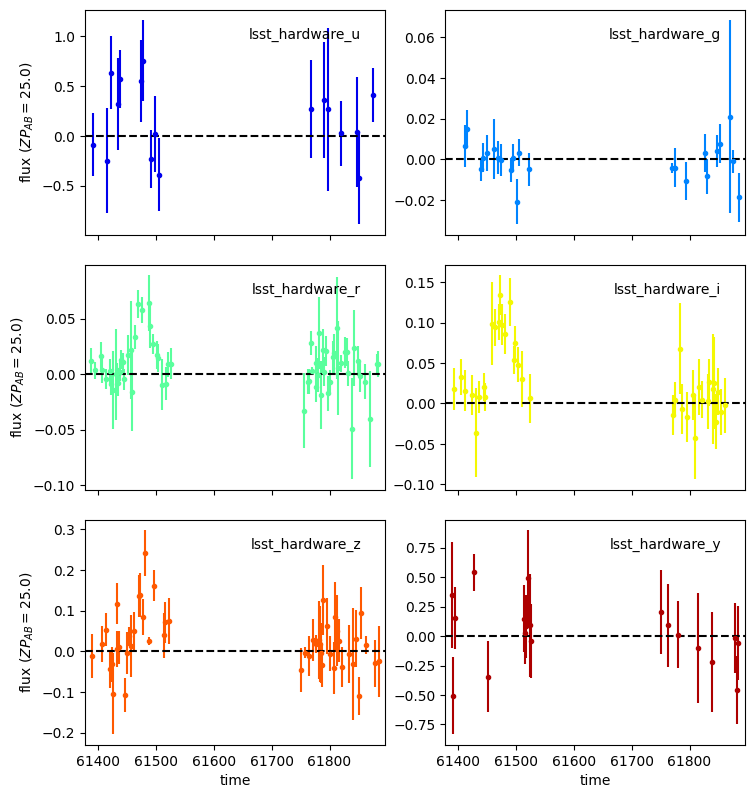

In [9]:
sncosmo.plot_lc(formatted_lc);


## Simulating Light-Curves

Since we need to add in our own atmospheric variability, the pre-tabulated flux values above are of limited use. Instead, we use the PLaSTICC meta-data to establish the cadence and model parameters for each simulated SN. This information is then used to simulate our own light-curves with `sncosmo`.


**Note:** See Issue 8 (https://github.com/LSSTDESC/SN-PWV/issues/8) for caveats about the following cell.

In [10]:
model_for_sim = sncosmo.Model('salt2-extended')
duplicated_lc = plasticc.duplicate_plasticc_sncosmo(plasticc_lc, model_for_sim, gain=20, skynr=100)


In [11]:
duplicated_lc.meta


{'t0': 61480.12109375,
 'x1': -0.6282458305358887,
 'c': -0.02218671888113022,
 'z': 0.7469527125358582,
 'x0': 3.089334056006399e-06}

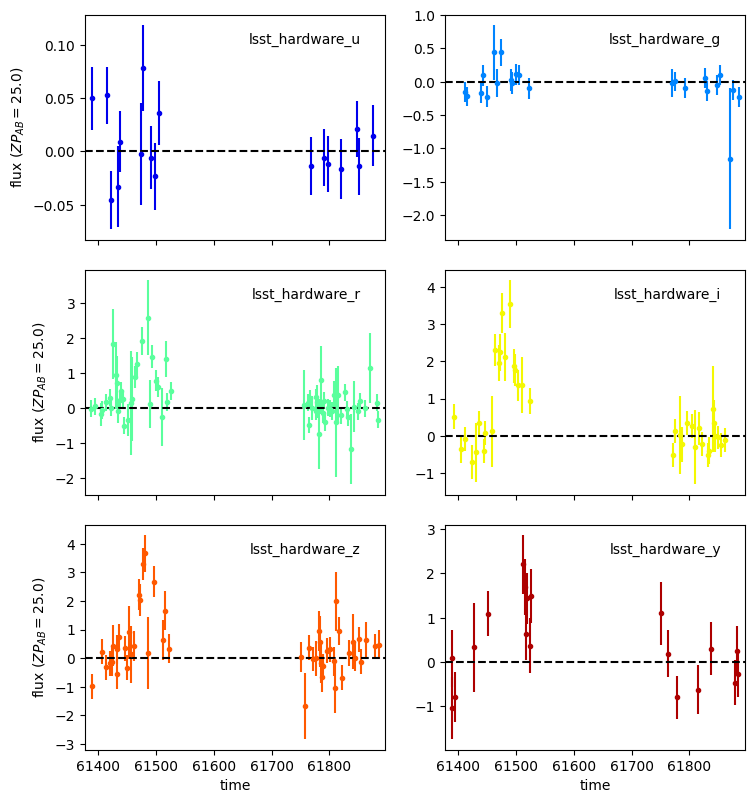

In [12]:
sncosmo.plot_lc(duplicated_lc);


In [13]:
duplicated_lc


time,band,flux,fluxerr,zp,zpsys
float64,str15,float64,float64,int64,str2
61387.3365,lsst_hardware_r,-0.02933052554479524,0.2420999845694427,25,ab
61389.3355,lsst_hardware_z,-0.9823007098968544,0.4379000027253873,25,ab
61389.3544,lsst_hardware_y,-1.0560485479778479,0.7090000119337073,25,ab
61390.3328,lsst_hardware_u,0.04971130937696528,0.0294000002693765,25,ab
61390.3514,lsst_hardware_y,0.07468428185986124,0.6444000110526767,25,ab
61392.2299,lsst_hardware_i,0.5120769295880192,0.3427999871994815,25,ab
61394.3293,lsst_hardware_r,0.038614360426412205,0.23790000684055865,25,ab
61394.3507,lsst_hardware_y,-0.7945505798528478,0.5670999948135992,25,ab
61405.2879,lsst_hardware_r,-0.19414417635961917,0.3169999968388855,25,ab


To simulate light-curves with PWV effects, we need 1) a model for the PWV over time, and 2) a Model for the SN that incorporates the PWV concentration along line of sight (i.e. the PWV scaled for the airmass at the time of observation). The first is easily defined as follows:

In [14]:
ctio = GPSReceiver('CTIO', data_cuts={'PWV': [(0, 25)]})
ctio.download_available_data(year=range(2012, 2018))
pwv_model = models.PWVModel.from_suominet_receiver(ctio, 2016, [2017])


For the second requirement, the `sncosmo` package doesn't have a clearly defined approach to adding time variable propagation effects. We use custom classes from the `snat_sim` package insetead, wich mimick `sncosmo` but include time variable propagation effects.

In [15]:
pwv_effect = models.VariablePWVTrans(pwv_model)
pwv_effect.set(res=5)

demo_model_with_pwv = models.Model(
    source='salt2-extended',
    effects=[pwv_effect],
    effect_names=[''],
    effect_frames=['obs']
)


In [16]:
def plot_variable_pwv_sn_model(model_with_pwv, phase=0, params=dict()):
    """Overplot a sncosmo model with and without temporally variable PWV
    
    Args:
        model_with_pwv (snat_sim.Model): sncosmo source to plot
        phase                   (float): Phase of the supernova to plot
        params                   (dict): Non-PWV related parameters for the model
    """
    
    wave = np.arange(3000, 12000)
    time = phase + params.get('t0', 0)

    model_without_pwv = sncosmo.Model(model_with_pwv.source)
    model_without_pwv.update({k: v for k, v in params.items() if k in model_without_pwv.param_names})
    flux_without_pwv = model_without_pwv.flux(time, wave)

    model_with_pwv.update(params)
    flux_with_pwv = model_with_pwv.flux(time, wave)

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.plot(wave, flux_without_pwv, label='Base Model', color='C1')
    ax.plot(wave, flux_with_pwv, label='Model with PWV', color='C0')
    ax.set_title('Simulated Flux')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.set_xlabel('Wavelength (A)')
    ax.set_xlim(min(wave), max(wave))

    plt.tight_layout()


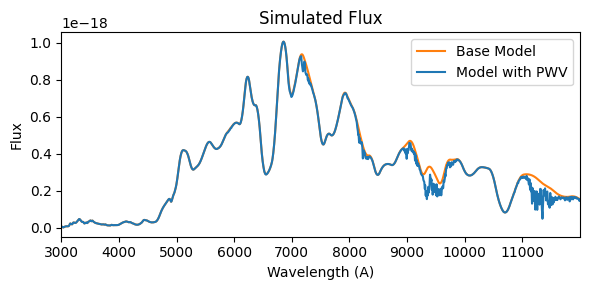

In [17]:
plot_variable_pwv_sn_model(
    demo_model_with_pwv,     
    params = {
        'z': 0.752069652,
        'x0': 3e-06,
        'x1': -1.8,
        'c': -0.1,
    }
)


## Airmass Scaling

We quickly validate the airmass calculation of the `VariablePWVTrans` class.


In [18]:
def plot_airmass_validation(cadence, model=11, mjd=0):
    """Plot the airmass of simulated PLaSTICC SNe locations as observed from LSST
    
    Args:
        cadence (str): Simulated PLaSTICC cadence to plot SNe for
        model   (int): Model number used in the PLaSTICC simulation
        mjd   (float): Date to plot airmasses for
    """
    
    ra = []
    dec = []
    peak = []

    header_path = plasticc.get_model_headers(cadence, 11)[0]
    header_data = fits.open(header_path)[1].data
    ra.extend(header_data['RA'])
    dec.extend(header_data['DECL'])
    
    if mjd == 'peak':
        peak.extend(header_data['PEAKMJD'])

    if mjd == 'peak':
        mjd = peak
    
    airmass = models.PWVModel.calc_airmass(time=mjd, ra=ra, dec=dec)
    is_positive_airmass = np.array(airmass) >= 0 
    positive_airmass = airmass[is_positive_airmass]
    
    lsst_coord = SkyCoord(constants.vro_latitude, constants.vro_longitude, unit=u.deg).galactic
    sn_coord = SkyCoord(ra, dec, unit=u.deg).galactic
    positive_coords = sn_coord[is_positive_airmass]
    negative_coords = sn_coord[~is_positive_airmass]
    
    plt.figure(figsize=(10, 5))
    plt.subplot(111, projection='aitoff')
    plt.grid(True)
    
    scat = plt.scatter(positive_coords.l.wrap_at('180d').radian, positive_coords.b.radian, c=positive_airmass, vmin=1, vmax=8, s=10)
    plt.scatter(negative_coords.l.wrap_at('180d').radian, negative_coords.b.radian, c='lightgrey', label='Over Horizon')
    plt.scatter(lsst_coord.l.wrap_at('180d').radian, lsst_coord.b.radian,color='C1', marker='*', s=100, label='VRO')
    plt.legend(framealpha=1)
    plt.colorbar(scat).set_label('Airmass', rotation=270, labelpad=15)
    

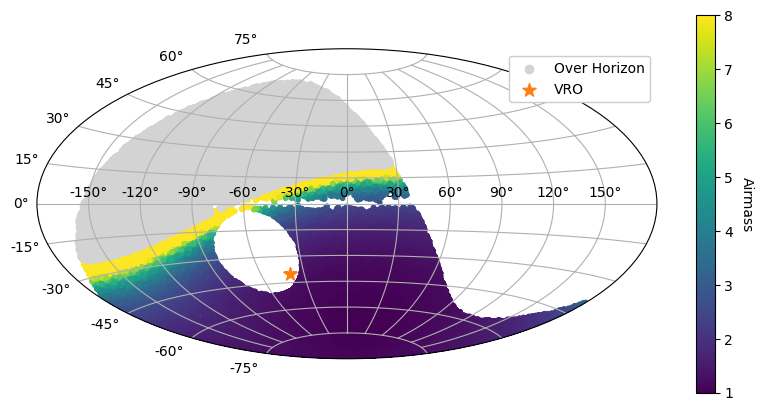

In [19]:
plot_airmass_validation(demo_cadence)
